In [46]:
import numpy as np
from sklearn.preprocessing import minmax_scale
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import datetime

Загрузим данные, сконвертируем unixtime в дату и отсортируем по времени.

In [47]:
data = pd.read_csv("test_data.csv", parse_dates=['time'], index_col='time')
data.drop('date', axis=1, inplace=True)
data.index = pd.to_datetime(data.index, unit='s')
data = data.sort_values(by='time')

## 1. Воспроизведите график числа рекламных событий по дням. 

In [22]:
data.head()

,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform
time,,,,,,,,
2019-04-01 00:00:48,click,CPM,0,no_agency,client_31916,campaign_44282,ad_44282,web
2019-04-01 00:01:03,view,CPC,0,no_agency,client_51,campaign_8339,ad_8339,android
2019-04-01 00:01:09,view,CPM,0,no_agency,client_108,campaign_10356,ad_10356,android
2019-04-01 00:01:19,view,CPC,0,no_agency,client_66,campaign_9343,ad_9344,android
2019-04-01 00:01:37,view,CPC,0,agency_33,client_99583,campaign_99650,ad_100610,android


Найдём сколько в каждом дне было рекламных событий

In [23]:
counts_by_day = data.resample('D').size()

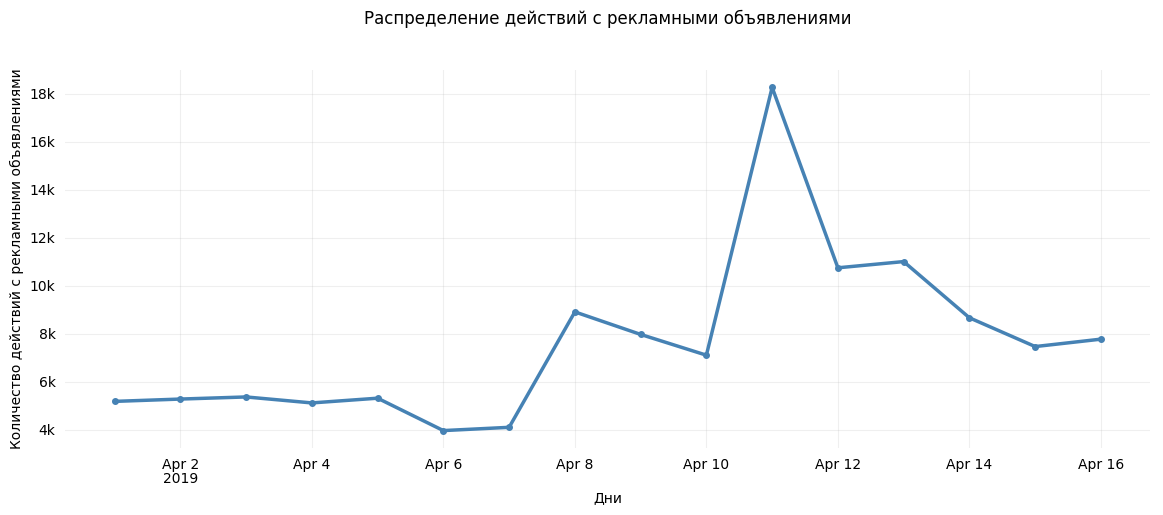

In [24]:
def plot(counts_by_day):
    fig, ax = plt.subplots(figsize=(14, 5), dpi=100)

    ax.plot(counts_by_day.index, counts_by_day, '.-', color='steelblue', linewidth=2.5, markersize=8)

    ax.set_xlabel("Дни")
    ax.set_ylabel("Количество действий с рекламными объявлениями")
    ax.set_title("Распределение действий с рекламными объявлениями", y=1.1)

    plt.tick_params(bottom=False, left=False, which='both')
    for s in ax.spines:
        ax.spines[s].set_visible(False)

    locator = dates.YearLocator()

    ax.xaxis.set_major_locator(dates.DayLocator(bymonthday=range(2,32,2)))
    ax.xaxis.set_major_formatter(dates.DateFormatter("%b %-d"))
    
    ax.xaxis.set_minor_locator(dates.YearLocator(month=4, day=2))
    ax.xaxis.set_minor_formatter(dates.DateFormatter("\n%Y"))
    
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000) + 'k'))

    plt.grid(alpha=0.2)
    
    return fig, ax
    
plot(counts_by_day)
plt.show()

## 2. Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло. 

По графику видим, что произошло увеличение в период с 8 по 16 апреля с резким пиком 11 апреля.
Дедуплицируем данные, чтобы убедиться, что это не ошибка сбора данных.

Row difference: 1136
Row difference (percentage): 0.93%


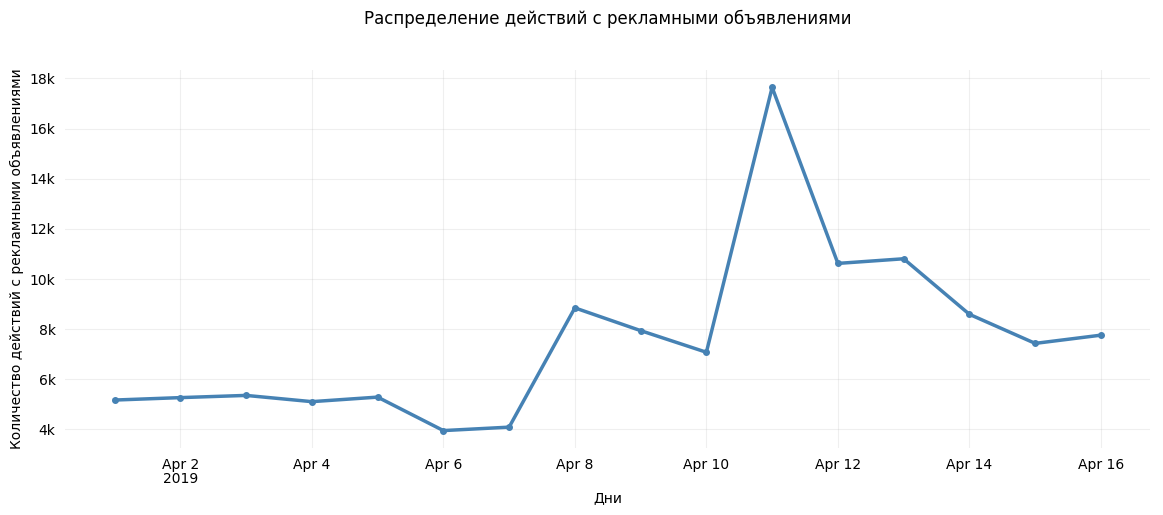

In [25]:
data_dedup = data.reset_index().drop_duplicates(inplace=False)
data_dedup.index = pd.to_datetime(data_dedup.time, unit='s')

print('Row difference: {}'.format(len(data) - len(data_dedup)))
print('Row difference (percentage): {:.2%}'.format((len(data) - len(data_dedup))/len(data)))

counts_by_day_dedup = data_dedup.resample('D').size()
plot(counts_by_day_dedup)
plt.show()

Как видим, некоторые данные повторялись, но общую картинку это не исказило (но скорее всего это действительно были люди, которые случайным образом в один и тот же момент посмотрели одно рекламное объявление). Далее будем работать с дедуплицированными данными.

In [7]:
data = data_dedup
data_slice = data['2019-04-08':'2019-04-16']

Посчитаем, сколько событий приходилось на каждую рекламу в эти дни.

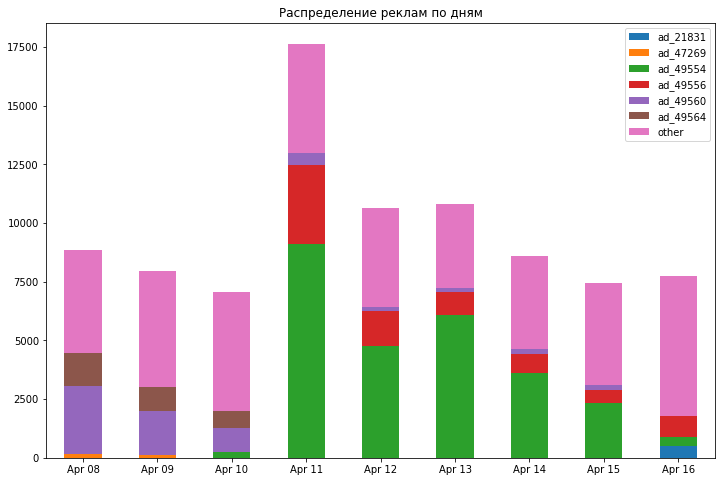

In [26]:
def f(grp, top=3):
    grp = grp.ad_id.value_counts()
    top5 = grp.iloc[:top]
    not_top5 = pd.Series(grp.iloc[top:].sum(), index=['other'])
    return top5.append(not_top5)

barplot_data = data_slice.resample('D').apply(f)
barplot_data = barplot_data.unstack()
barplot_data.index = pd.to_datetime(barplot_data.index).map(lambda x: x.strftime("%b %d"))

barplot_data.plot(kind='bar', stacked=True, figsize=(12,8), title="Распределение реклам по дням", rot=0)
plt.show()

Что мы видим:

8 апреля около половины трафика генерировали рекламы `ad_49560`, `ad_49564`, потом начался спад.
Также видим, что на пике с 11 по 13 апреля, около 70% рекламных событий приходилось на топ-3 рекламы: `ad_49554`, `ad_49556` и `ad_49560` (в гораздо меньшей степени).

Потом, эти рекламы также составляли весомую часть, но пошли на спад.

Можем посмотреть, кто их сделал:

In [27]:
ad_ids = ["ad_49564", "ad_49554", "ad_49556", "ad_49560"]
data[data["ad_id"].isin(ad_ids)][["agency_union_id", "client_union_id", "campaign_union_id"]].apply(np.unique)

,agency_union_id,client_union_id,campaign_union_id
0,agency_2,client_47270,campaign_49554


Вывод: резкое увеличение рекламных собитий произошло в результате кампании `campaign_49554` от агенства `agency_2`.

## З*. Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики. Иными словами, предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день. Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике? 

Идея такова:

будем смещать окно определенной ширины и в нём считать среднее и стандартное отклонение. Если какой-то датапоинт будет подчиняться уравнению:

$$ x_{\textrm day} > {\bar x} + ks$$

где $x_{\textrm day}$ -- значение в текущем дне, ${\bar x}$ и $s$ среднее и среднеквадратическое отклонение за некоторый период, $k$ - некоторая константа, то будем считать его аномальным.

### Дни

In [34]:
def plot_outliers(ax, count_data):
    ax.plot(count_data.index, count_data, '.', color='red', linewidth=2.5, markersize=8)

In [37]:
def detect_outliers(counts, period=3, std_coef=1):
    norm_counts = minmax_scale(counts.astype(float))
    norm_counts = pd.Series(norm_counts, index=counts.index)
    outliers = norm_counts.rolling(period).median() + std_coef * norm_counts.rolling(period).std()
    outliers = outliers < norm_counts[outliers.index]
    outliers = counts[outliers]

    if len(outliers) > 0:
        print("На этом графике есть проблема")
        
    return outliers

На этом графике есть проблема


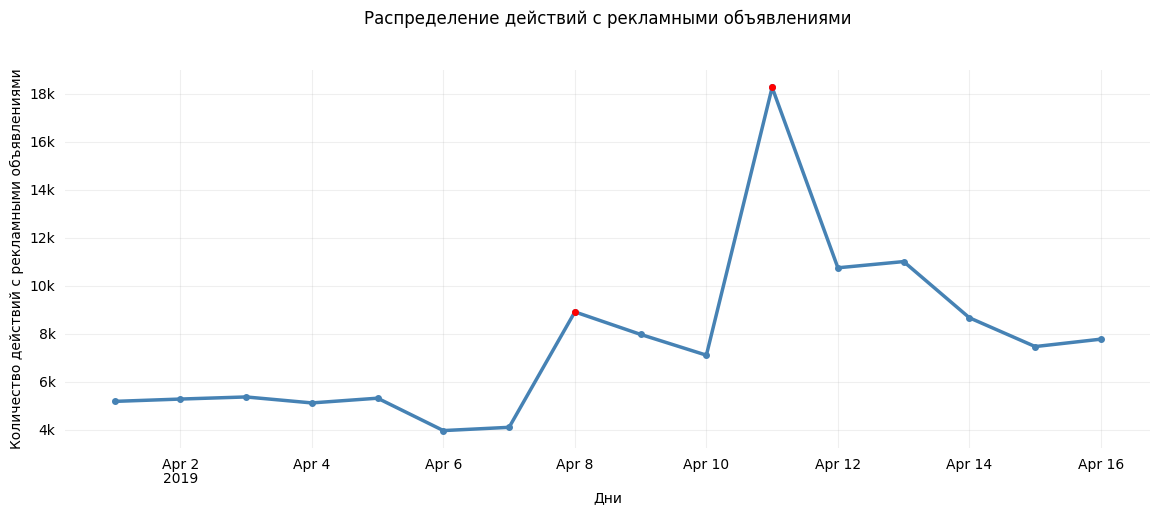

In [38]:
daily_counts = data.resample('D').apply(lambda x: x.ad_id.value_counts().sum())
fig, ax = plot(daily_counts)
outliers = detect_outliers(daily_counts)
plot_outliers(ax, outliers)
plt.show()

### Часы

На этом графике есть проблема


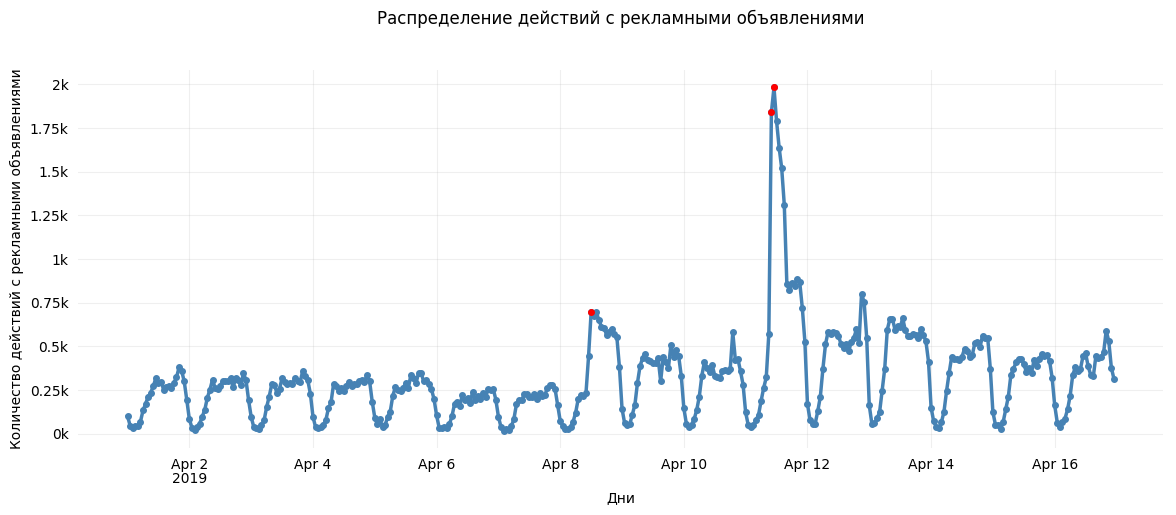

In [42]:
hour_counts = data.resample('H').apply(lambda x: x.ad_id.value_counts().sum())

fig, ax = plot(hour_counts)
outliers = detect_outliers(hour_counts, period=24, std_coef=3)
plot_outliers(ax, outliers)
plt.show()

### Пятиминутки

На этом графике есть проблема


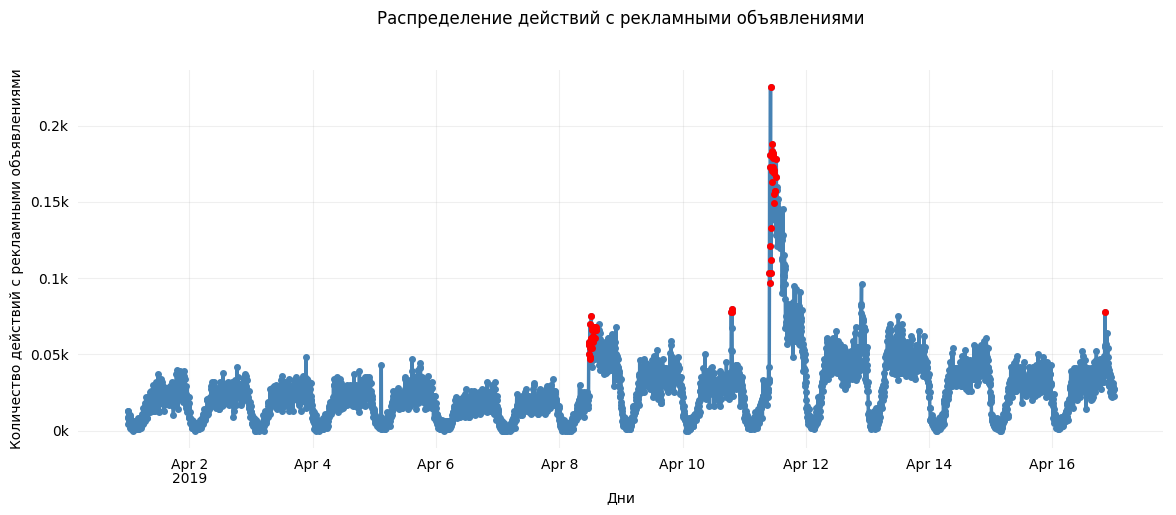

In [45]:
min_counts = data.resample('5T').apply(lambda x: x.ad_id.value_counts().sum())

fig, ax = plot(min_counts)
outliers = detect_outliers(min_counts, period=300, std_coef=3)
plot_outliers(ax, outliers)
plt.show()